In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import csv 
import math
from skimage import measure, morphology

In [2]:
INPUT_FOLDER="/home/usma/Desktop/Research_Project/practical/stage1/"

In [3]:
patients = os.listdir(INPUT_FOLDER)
patients.sort()
NoSlices=40

In [4]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [5]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
#         print(image.shape)
    
    return np.array(image, dtype=np.int16)

In [6]:
def chunks(l, n):
    count = 0
    for i in range(0, len(l), n):
        if (count < NoSlices):
            yield l[i:i + n]
            count = count + 1


def mean(l):
    return sum(l) / len(l)

In [7]:

def make_chunks(slices):
    new_slices=[]
    chunk_sizes = math.floor(len(slices) / NoSlices)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)
    #     print(len(slice_chunk))
#     print(len(slice_chunk))
    return np.array(new_slices)

In [8]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [9]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes_classic(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.savefig("lung3D1")
    plt.show()

In [10]:
for patient in patients[8:9]:
#     print(patient)
#     if os.path.exists("../preprocessed_images/"+patient+".npy"):
#         print("exists")
#         continue
    slices=load_scan(INPUT_FOLDER+patient)
    
    hu_image=get_pixels_hu(slices)
    print(hu_image.shape)
    
    segmented_lung=  segment_lung_mask(hu_image)
    final_image = segmented_lung * hu_image
#     plot_3d(final_image)
    
#     plt.hist(image.flatten(), bins=50, color='c')
#     plt.xlabel("Hounsfield Units (HU)")
#     plt.ylabel("Frequency")
#     plt.show()
#     chunk_images = make_chunks(hu_image)
#     chunk_images = make_chunks(hu_image)
#     print("Patient :",patient, "Original shape: " ,image.shape, "New shape: ", chunk_images.shape)

#     np.save("/media/usma/New Volume/preprocess_2/{}".format(patient),image)

(135, 512, 512)


In [11]:
segmented_lungs_fill = segment_lung_mask(hu_image, True)

In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
plot_3d(hu_image, 30)

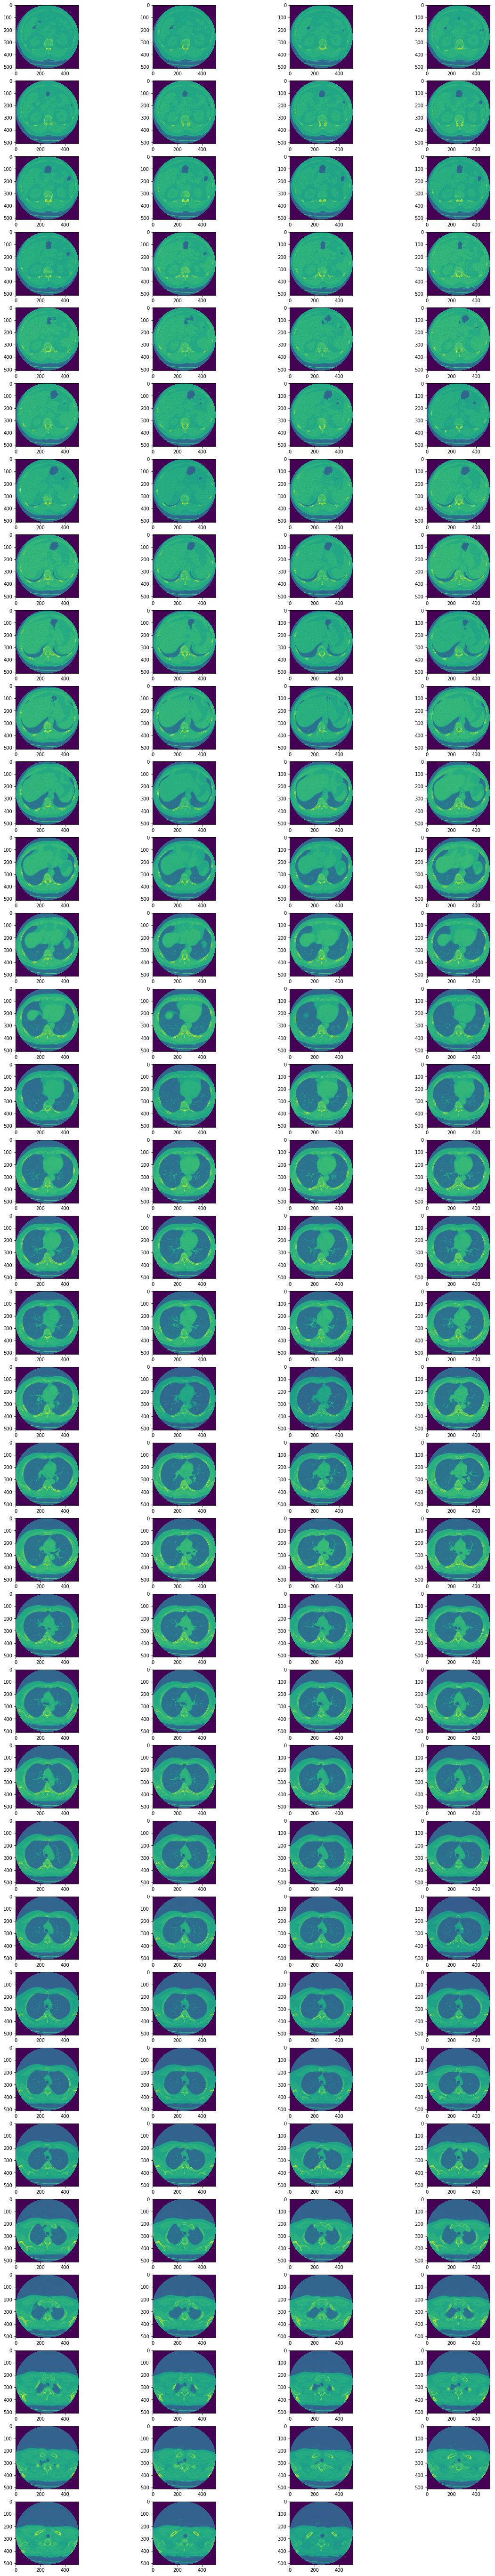

In [44]:
plt.figure(figsize=(20,100))
columns = 4
for i, image in enumerate(hu_image):
#     print(image.shape)
    plt.subplot(len(hu_image) / columns + 1, columns, i + 1)
    plt.imshow(image)

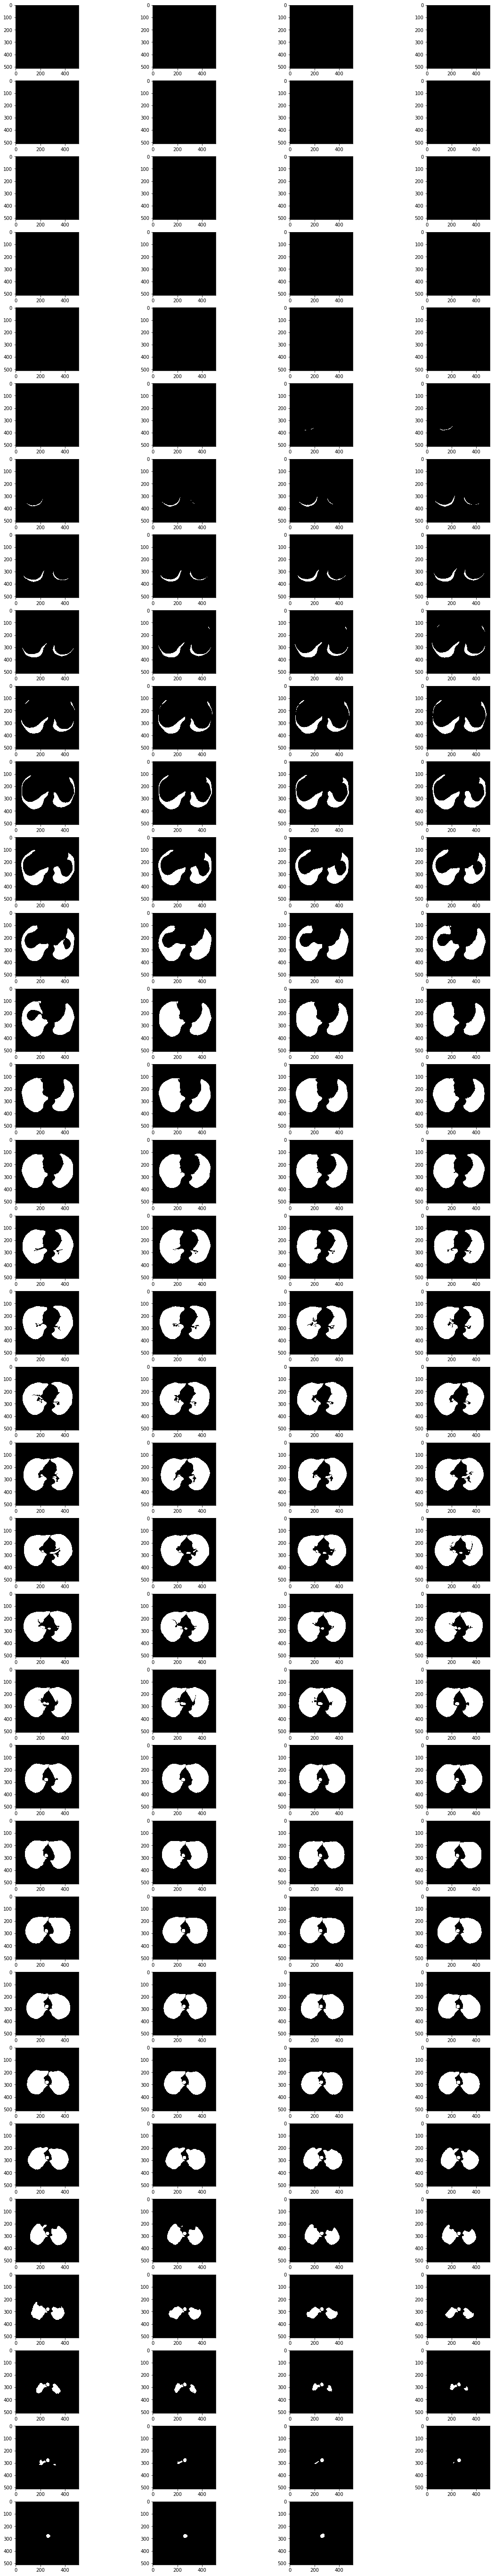

In [11]:
plt.figure(figsize=(20,100))
columns = 4
for i, image in enumerate(segmented_lung):
#     print(image.shape)
    plt.subplot(len(segmented_lung) / columns + 1, columns, i + 1)
    plt.imshow(image,cmap='gray')

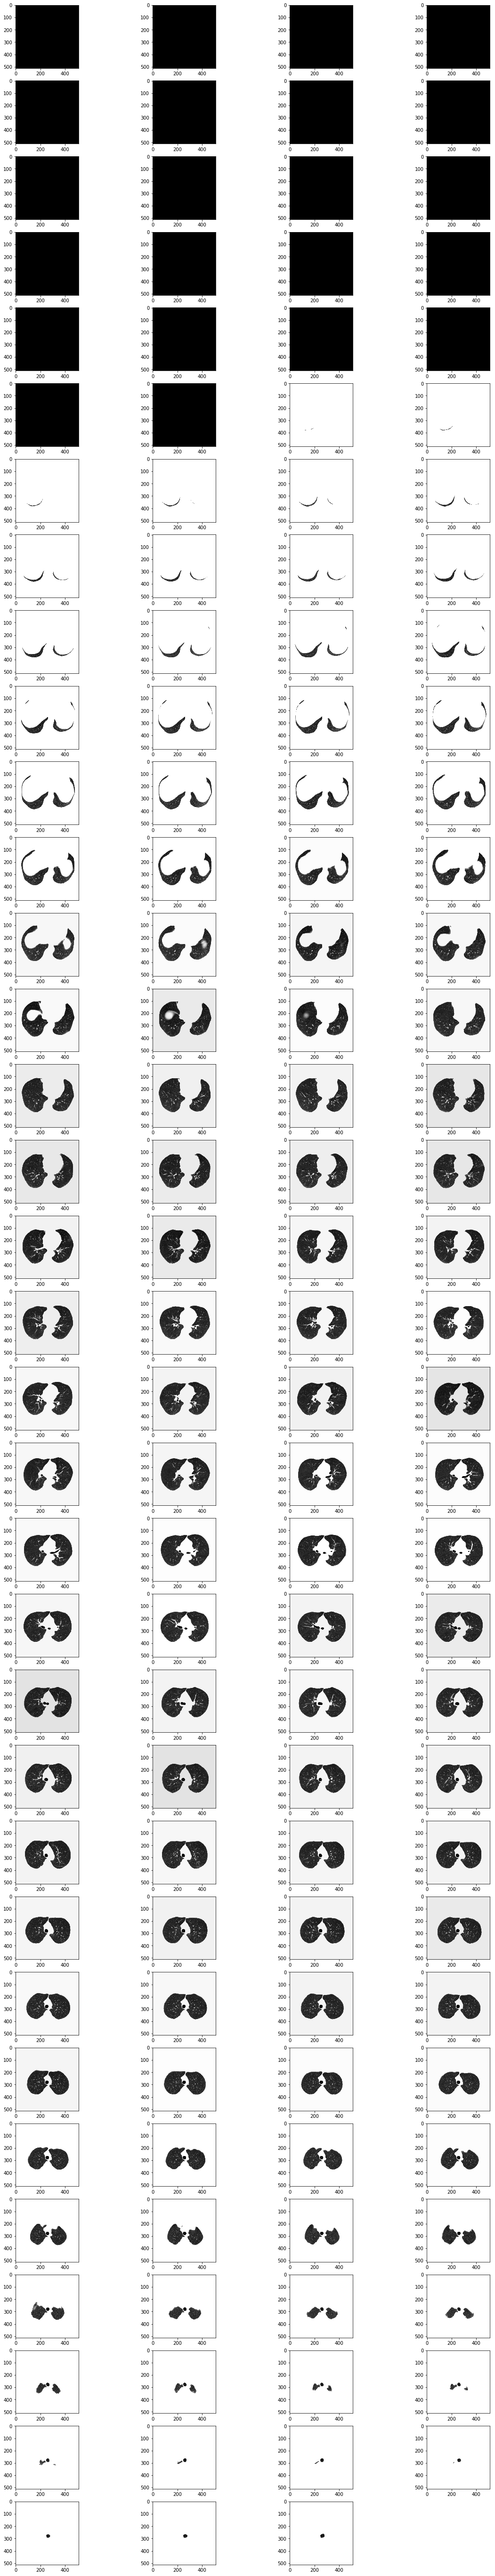

In [12]:
plt.figure(figsize=(20,100))
columns = 4
for i, image in enumerate(final_image):
#     print(image.shape)
    plt.subplot(len(final_image) / columns + 1, columns, i + 1)
    plt.imshow(image,cmap='gray')

In [12]:
hu_image.max()

4095

In [13]:
hu_image.min()

0

In [13]:
print(patient)

00edff4f51a893d80dae2d42a7f45ad1
